## FERM 508 - Group 6 - Final Project
### Project Group Members: Nafiz Emir Eğilli, Burak Kargın, Mert Şengün

------------------------
## Using Daily News Sentiment Index to predict Amazon Inc (AMZN) Returns

For this project, we aim to use Daily News Sentiment Index from https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/

The Daily News Sentiment Index is a high-frequency indicator of economic sentiment derived from lexical analysis of news articles focused on economics. This index, detailed in the works of Buckman, Shapiro, Sudhof, and Wilson (2020), builds on the methodology developed by Shapiro, Sudhof, and Wilson (2020). In their approach, Shapiro, Sudhof, and Wilson (2020) (hereafter referred to as SSW) calculate sentiment scores from economics-related news articles sourced from 24 prominent U.S. newspapers via the Factiva news aggregator service. These newspapers represent major regions across the United States and include publications with significant national reach, such as the New York Times and the Washington Post. SSW utilize articles with a minimum of 200 words, where Factiva has classified the topic as "economics" and the subject country as "United States."

Sentiment analysis involves quantifying the emotional tone of textual data, where in this project utilized in the form of Daily News Sentiment Index as a proxy for market sentiment, hypothesizing that positive sentiment correlates with rising stock prices, while negative sentiment correlates with falling prices.

We will combine this sentiment index with daily Nasdaq 100 (^NDX) index data collected from Yahoo Finance, along with daily price data for Amazon Inc. (AMZN) to create a predictive model based on Long Short Term Memory (LSTM) networks, a type of recurrent neural network (RNN) well-suited for time-series prediction due to their ability to retain and utilize long-term dependencies. 

By integrating the Daily News Sentiment Index with daily Nasdaq 100 (^NDX) index data and daily price data for Amazon Inc. (AMZN), the project aims to predict AMZN returns. The LSTM model's architecture allows it to capture the temporal dependencies and patterns in the data, providing a robust framework for prediction.

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner
from keras_tuner import Hyperband

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to load data
def load_data(file_path, sheet_name='Data'):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data.set_index('date', inplace=True)
    return data

# Function to preprocess data
def preprocess_data(data, target_col, window_size=60):
    features = data.drop(target_col, axis=1)
    target = data[target_col]

    # Fill NaN values if any
    features.fillna(method='ffill', inplace=True)
    target.fillna(method='ffill', inplace=True)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

    # Create sequences
    X, y = [], []
    for i in range(window_size, len(scaled_features)):
        X.append(scaled_features[i-window_size:i])
        y.append(scaled_target[i])
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Function to plot data
def plot_data(data, column, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel(f'{column} Returns')
    plt.title(title)
    plt.legend()
    plt.show()

# Function to build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and evaluate LSTM model
def train_evaluate_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the predicted values
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_scaled = scaler.inverse_transform(y_pred)

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_scaled, label='Actual Returns')
    plt.plot(y_pred_scaled, label='Predicted Returns')
    plt.title('AMZN Returns Prediction')
    plt.xlabel('Days')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

    return model

# Function to build and tune the LSTM model
def build_tuned_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Choice('units', [32, 64, 128]),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))
    model.add(LSTM(units=hp.Choice('units', [32, 64, 128])))
    model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


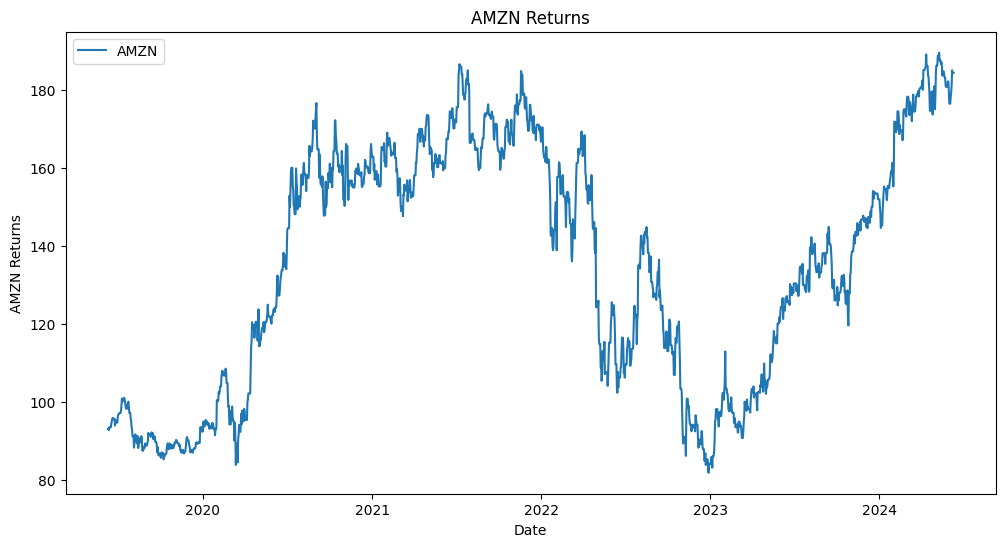

In [3]:
# Load and preprocess data
amzn_data = yf.download('AMZN', start='2019-06-10', end='2024-06-10')
ndx_data = yf.download('^NDX', start='2019-06-10', end='2024-06-10')
news_sentiment_data = load_data('news_sentiment_data.xlsx')

# Combine data into a single DataFrame
combined_data = news_sentiment_data.copy()
combined_data['AMZN'] = amzn_data['Adj Close']
combined_data['NDX'] = ndx_data['Adj Close']
combined_data.rename(columns={'News Sentiment': 'Sentiment'}, inplace=True)
combined_data = combined_data[['AMZN', 'Sentiment', 'NDX']]
combined_data.fillna(method='ffill', inplace=True)

# Plot data
plot_data(combined_data, 'AMZN', 'AMZN Returns')

Epoch 1/20
45/45 [==============================] - 5s 41ms/step - loss: 0.3907 - val_loss: 0.2990
Epoch 2/20
45/45 [==============================] - 1s 23ms/step - loss: 0.2959 - val_loss: 0.2584
Epoch 3/20
45/45 [==============================] - 1s 23ms/step - loss: 0.2420 - val_loss: 0.2269
Epoch 4/20
45/45 [==============================] - 1s 23ms/step - loss: 0.1998 - val_loss: 0.1879
Epoch 5/20
45/45 [==============================] - 1s 24ms/step - loss: 0.2180 - val_loss: 0.2312
Epoch 6/20
45/45 [==============================] - 1s 24ms/step - loss: 0.1870 - val_loss: 0.1345
Epoch 7/20
45/45 [==============================] - 1s 25ms/step - loss: 0.1403 - val_loss: 0.1310
Epoch 8/20
45/45 [==============================] - 1s 24ms/step - loss: 0.1398 - val_loss: 0.1001
Epoch 9/20
45/45 [==============================] - 1s 24ms/step - loss: 0.0972 - val_loss: 0.0629
Epoch 10/20
45/45 [==============================] - 1s 23ms/step - loss: 0.0833 - val_loss: 0.0652
Epoch 11/

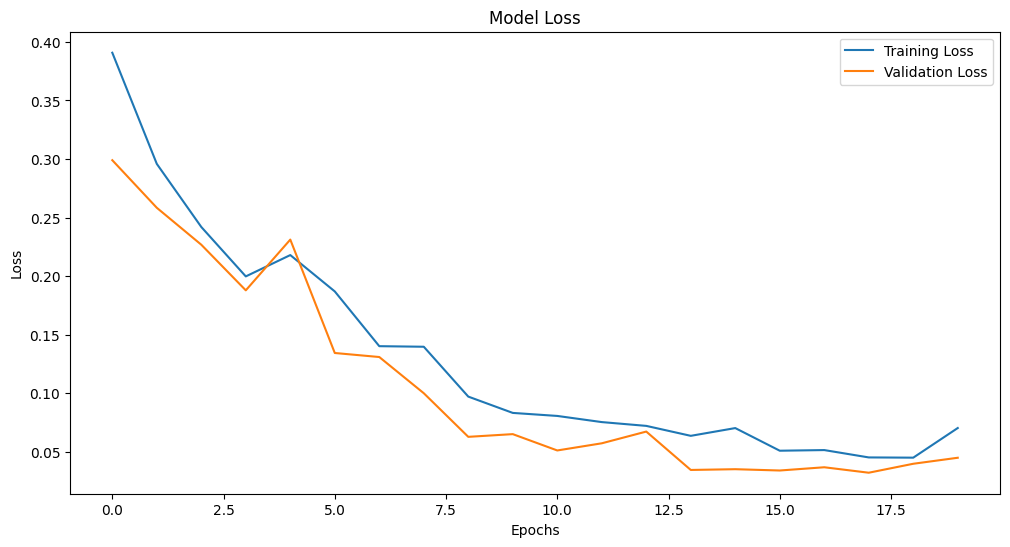

6/6 [==============================] - 1s 8ms/step


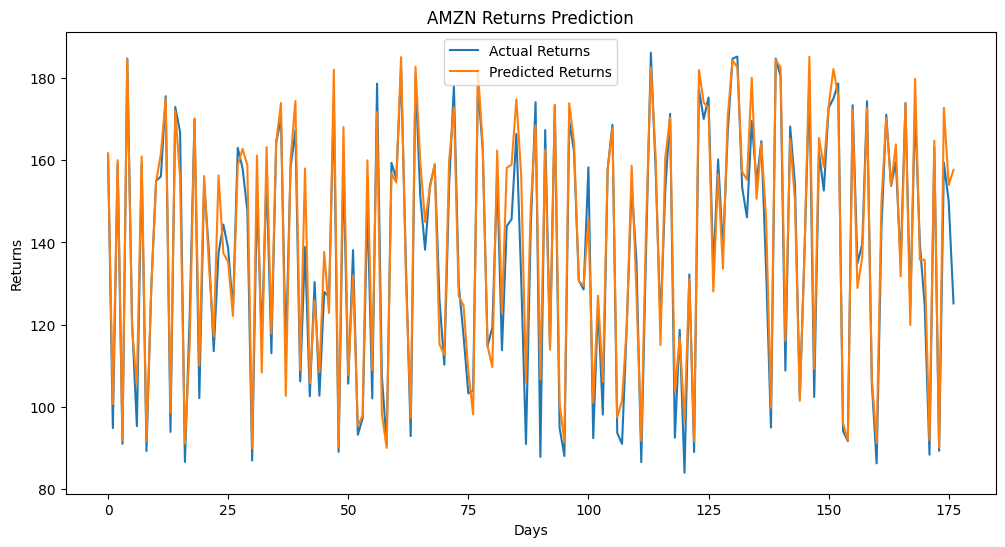

In [4]:
# Ensure that the combined data has no NaN values
combined_data.fillna(method='ffill', inplace=True)
combined_data.dropna(inplace=True)

# Preprocess data
X, y, scaler = preprocess_data(combined_data, target_col='AMZN')

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train and evaluate LSTM model
lstm_model = train_evaluate_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, scaler)

### Model Loss Plot:
- Trends: Both training and validation losses decrease initially, indicating good learning.
- Convergence: Validation loss stabilizes around epoch 14.
- Validation vs. Training Loss: Validation loss is generally lower, suggesting good generalization.
### AMZN Returns Prediction Plot:
- Alignment: High alignment between actual and predicted returns, indicating effective pattern capture.
- Volatility: Model captures the high volatility in returns well.
### Training Loss and Validation Loss Logs:
- Initial Epochs: Rapid decrease in loss, showing effective learning.
- Stabilization: Losses stabilize around epoch 14-20.

In [5]:
# Hyperparameter tuning using Keras Tuner
tuner = Hyperband(
    build_tuned_lstm_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_dir',
    project_name='lstm_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 18 Complete [00h 00m 07s]
val_loss: 0.2559027075767517

Best val_loss So Far: 0.2269815355539322
Total elapsed time: 00h 02m 07s


In [6]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_scaled = scaler.inverse_transform(y_pred)

# Calculate and print performance metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)
print("Test Mean Squared Error:", mse)
print("Test Mean Absolute Error:", mae)
print("Test R-squared:", r2)

6/6 [==============================] - 1s 7ms/step
Test Mean Squared Error: 237.27314820142016
Test Mean Absolute Error: 12.887839064086224
Test R-squared: 0.7385773716984688


### COMMENT:
The best validation loss achieved was 0.227 after 2 minutes and 7 seconds. On the test set, the model showed a Mean Squared Error (MSE) of 237.27, Mean Absolute Error (MAE) of 12.89, and R-squared (R²) of 0.739, indicating a good fit and significant variance explained. 

Next steps include residual analysis for patterns or biases, plotting actual vs. predicted returns, and analyzing error distribution.

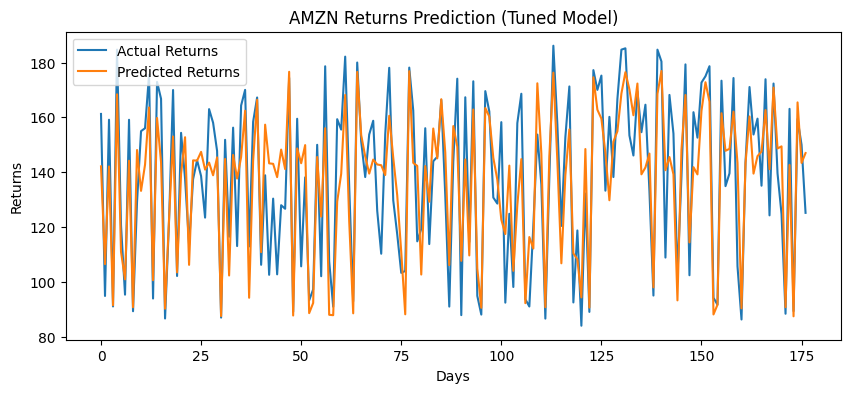

Best Hyperparameters:
units: 32
dropout_rate: 0.2
optimizer: rmsprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


In [7]:
# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 4))
plt.plot(y_test_scaled, label='Actual Returns')
plt.plot(y_pred_scaled, label='Predicted Returns')
plt.title('AMZN Returns Prediction (Tuned Model)')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Print best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

The plot shows the actual vs. predicted returns for Amazon (AMZN) using the tuned model. The model appears to capture the general trends and volatility well, with the best hyperparameters being 32 units, a dropout rate of 0.2, and using the RMSprop optimizer. The model was trained for 2 epochs. The close alignment of the actual and predicted returns suggests the model's effectiveness in capturing return patterns.

Summary statistics of residuals:
                0
count  177.000000
mean     1.085420
std     15.408973
min    -40.650810
25%    -11.615898
50%      1.888916
75%     13.802307
max     35.568924


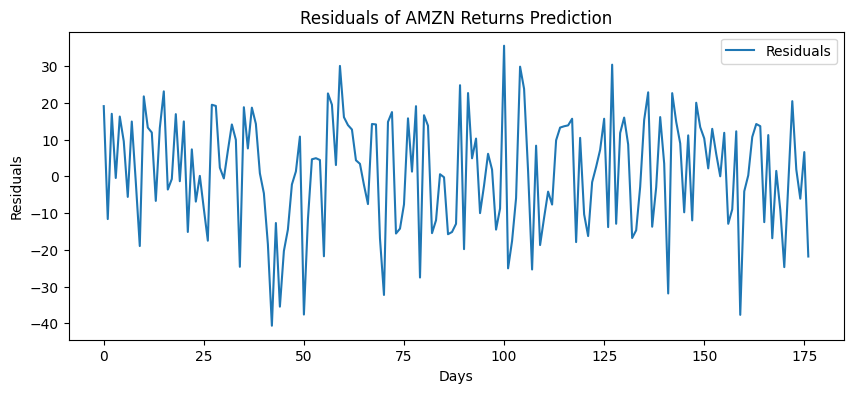

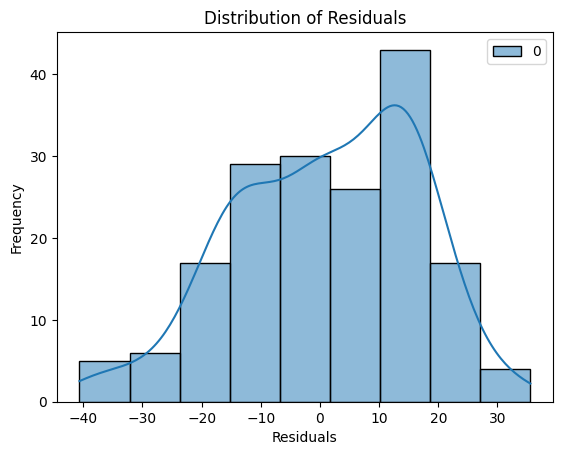

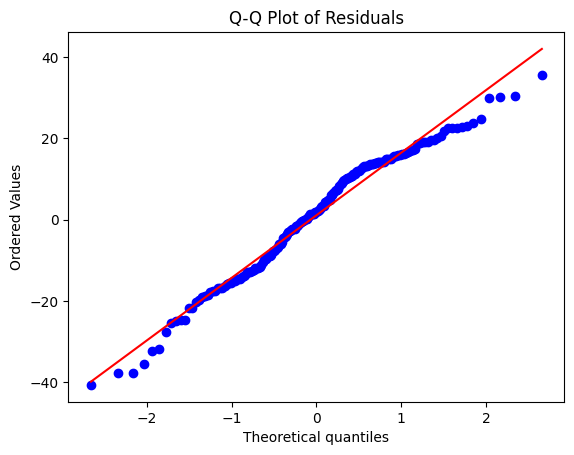

In [8]:
# Error Analysis
# Calculate residuals
residuals = y_test_scaled - y_pred_scaled

# Summary statistics of residuals
print("Summary statistics of residuals:")
print(pd.DataFrame(residuals).describe())

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of AMZN Returns Prediction')
plt.xlabel('Days')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Plot distribution of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

- The residual plot shows no clear pattern, indicating randomness in errors. 
- The distribution plot suggests residuals follow a normal distribution, with most close to zero, implying accurate predictions. 
- The Q-Q plot confirms normality with slight deviations at extremes. 
- Summary statistics show a mean residual of 1.09 (close to zero, indicating no bias) and a standard deviation of 15.41, with residuals ranging from -40.65 to 35.57. 

Overall, the residuals are normally distributed and unbiased, confirming the model's reliability.

### Warning: Execute the code below only if you need to clear the hyperband directory to re-run the code

In [ ]:
import shutil

In [ ]:
# Clear previous hyperband directory
shutil.rmtree('hyperband_dir')